# (20) Source data -- ```KABA```

**Motivation**: Save all the source data required for figures. This includes:

1. Degree ranks (Figure 6B)
2. Grads (Figure 8)

<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


from figures.fig_ocs import bwor_cmap


def _show_sim(
    sim, align: bool = False,
    figsize=(15, 5.1), fontsize=12, ):
    _n = len(list(sim.values())[0])
    ticklabels = np.array([f'G{i+1}' for i in range(_n)])
    fig, axes = create_figure(1, 3, figsize, 'all', 'all', 'constrained')
    
    for i, (k1, k2) in enumerate(itertools.combinations(grads, 2)):
        
        x = sim[(k1, k2)]
        if align:
            a, b = sp_optim.linear_sum_assignment(
                cost_matrix=np.abs(x), maximize=True)
            x = x[a][:, b]
            xticklabels = ticklabels[b]
            yticklabels = ticklabels[a]
        else:
            xticklabels = yticklabels = ticklabels
        
        ax = axes.flat[i]
        sns.heatmap(
            data=x,
            cmap=bwor_cmap('corr'),
            vmin=-1,
            vmax=1,
            linewidths=0.2,
            linecolor='dimgrey',
            cbar=False,
            square=True,
            annot=True,
            fmt="0.2f",
            annot_kws={'fontsize': fontsize},
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax,
        )
        ax.set_ylabel(k1, fontsize=25)
        ax.set_xlabel(k2, fontsize=25, labelpad=12)
        ax.tick_params(labelsize=17)
    return fig


def _show_scatter(df, mode):
    fig, axes = create_figure(4, 4, (9.5, 9.5), layout='constrained')

    d2p = df.loc[df['mode'] == mode]
    for i, j in itertools.product(range(4), range(4)):
        ax = axes[i, j]
        sns.scatterplot(
            data=d2p,
            y=f'G-{i+1}',
            x=f'G-{j+1}',
            hue='partition',
            hue_order=colors,
            palette=colors,
            ax=ax,
        )
        move_legend(ax)
        ax_square(ax)

    for i, j in list(zip(*np.tril_indices(4, k=-1))):
        axes[i, j].remove()

    plt.show()
    return fig


def _show_grads(x):
    _n = x.shape[1]
    fig, _ = bs.show(
        data={
            k: x[i] for i, k in
            enumerate(grads)},
        vmin=-2.0, vmax=2.0, figsize=(1.8 * _n, 4.5), dpi=180,
        titles=[f"G-{i+1}" for i in range(_n)],
        cbar=True, cbar_pad=0.12, cbar_aspect=15, cbar_shrink=0.8,
        label_pad=15, label_fontsize=16,
        cmap='Spectral_r', contour_cmap='Greys_r',
        layout='constrained',
    )
    return fig


def _show_grads_save(x):
    _n = x.shape[1]
    fig, _ = bs.show(
        data={
            k: x[i] for i, k in
            enumerate(grads)},
        vmin=-2.0, vmax=2.0, figsize=(1.8 * _n, 4.5), dpi=180,
        titles=False, add_ylabels=False, cbar=False,
        cmap='Spectral_r', contour_cmap='Greys_r',
        layout='constrained', wscape=0, hspace=0,
    )
    return fig


def _show_lambs(lambs):
    fig, axes = create_figure(1, 3, (9, 2.8), sharex='all', layout='constrained')

    g_both = {}
    for i, (k, v) in enumerate(lambs.items()):
        axes[i].axvline(4, color='k', ls='--', lw=1, label='cutoff')
        axes[i].plot(
            range(1, len(v) + 1), v,
            marker='o', markersize=5,
            lw=1, color=pal[k], label=k)
        axes[i].legend(fontsize=13, loc='best')
        axes[i].grid()
    axes[0].set(xscale='log')
    plt.show()
    return fig


def _show_lambs_shared(lambs, figsize=(4, 3)):
    fig, ax = create_figure(1, 1, figsize)
    ax.axvline(4, color='k', ls='--', lw=1, label='cutoff')

    g_both = {}
    for i, (k, v) in enumerate(lambs.items()):
        x = v / sum(v)
        x *= 100
        ax.plot(
            range(1, len(v) + 1), x,
            marker='o', markersize=5,
            lw=1.3, color=pal[k], label=k)
        ax.legend(fontsize=13, loc='best')
    ax.set(xscale='log', xlabel='', ylabel='')
    ax.grid()
    # ax.set_xlabel('Component', fontsize=13)
    # ax.set_ylabel('Variance [%]', fontsize=13)
    plt.show()
    return fig


def get_sim(x, labels):
    _n = x.shape[1]
    sim = {
        (k1, k2): np.zeros((_n, _n)) for k1, k2
        in itertools.product(labels, labels)
    }
    for i0, j0 in itertools.product(range(3), range(3)):
        for i1, j1 in itertools.product(range(_n), range(_n)):
            key = (labels[i0], labels[j0])
            sim[key][i1, j1] = sp_stats.pearsonr(
                x[i0, i1], x[j0, j1],
            ).statistic
    return sim


def get_x2p(g, num=7, zscore=True, delete={BOLD: 2, CAS: 7, CAF: 7}):
    x2p = np.zeros((3, 8, bs.num_n))
    for i, (mode, x) in enumerate(g.items()):
        for j in range(8):
            _x = x[j]
            if zscore:
                x2p[i, j] = sp_stats.zscore(_x)
            else:
                x2p[i, j] = _x
    
    if delete is not None:
        x2p_final = np.zeros((3, 7, bs.num_n))
        for i, i_del in enumerate(delete.values()):
            ids = np.delete(np.arange(8), i_del)
            x2p_final[i] = x2p[i][ids]
    else:
        x2p_final = x2p
    x2p_final[1, 0] *= -1
    x2p_final[1, 2] *= -1
    return x2p_final[:, :num, :]


def get_df(x, partition, labels):
    df = []
    for i, mode in enumerate(labels):
        good = np.isfinite(partition[mode])
        disjoint = [
            f"OC-{i:0.0f}" for i in
            partition[mode][good]
        ]
        df.append({
            'mode': [mode] * good.sum(),
            'partition': disjoint,
            'G-1': x[i][0, good],
            'G-2': x[i][1, good],
            'G-3': x[i][2, good],
            'G-4': x[i][3, good],
        })
    df = pd.DataFrame(merge_dicts(df))
    return df

## Prep

In [3]:
mice = Mice(512)
bs = Base(mice, mode='ca2')
kws_show = show_kws(7)

pal = prepare_palette()
cmap, colors = get_cluster_cmap(range(7), return_colors=True)
colors = {f"OC-{i+1}": c for i, c in enumerate(colors)}
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

save_dir = pjoin(fig_base_dir, 'rebuttal', 'source_data')
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal/source_data

## Degree ranks

In [4]:
dr = np.load(
    pjoin(tmp_dir, 'degree_ranks.npy'),
    allow_pickle=True,
).item()

### Plot (for the recod)

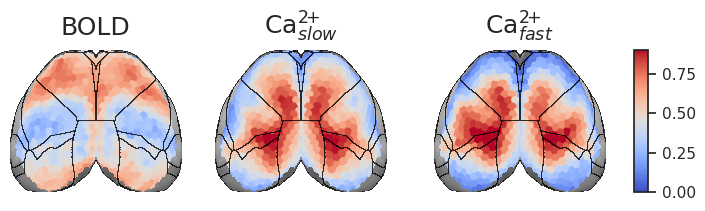

In [5]:
fig, _ = bs.show(
    data=np.stack([v for v in dr.values()]),
    titles=[translation[k] for k in dr],
    figsize=(7, 2.0), vmin=0, vmax=0.9, 
    label_fontsize=18, title_y=1.05,
    cbar_pad=0.15, cbar=True, cbar_aspect=10,
    cmap='coolwarm', contour_cmap='Greys_r',
    layout='constrained',
)

### Save CSV

In [6]:
sd = pd.DataFrame(dr)
sd.to_csv(pjoin(save_dir, "Fig6B.csv"), index=False)

## Grads

In [7]:
hemis = 'both'

# grads & lambs
grads = np.load(
    pjoin(tmp_dir, 'grads.npy'),
    allow_pickle=True,
).item()
lambs = grads['lambs'][hemis]
grads = grads['grads'][hemis]

# pi & partition
pi = np.load(
    pjoin(tmp_dir, 'memberships_avg.npy'),
    allow_pickle=True,
).item()
partition = {
    mode: bs.disjoint_community(pi[f"preproc\n{mode}"])
    for mode in grads
}

### 4 x grads

In [8]:
num = 4
x = get_x2p(grads, num, zscore=True)

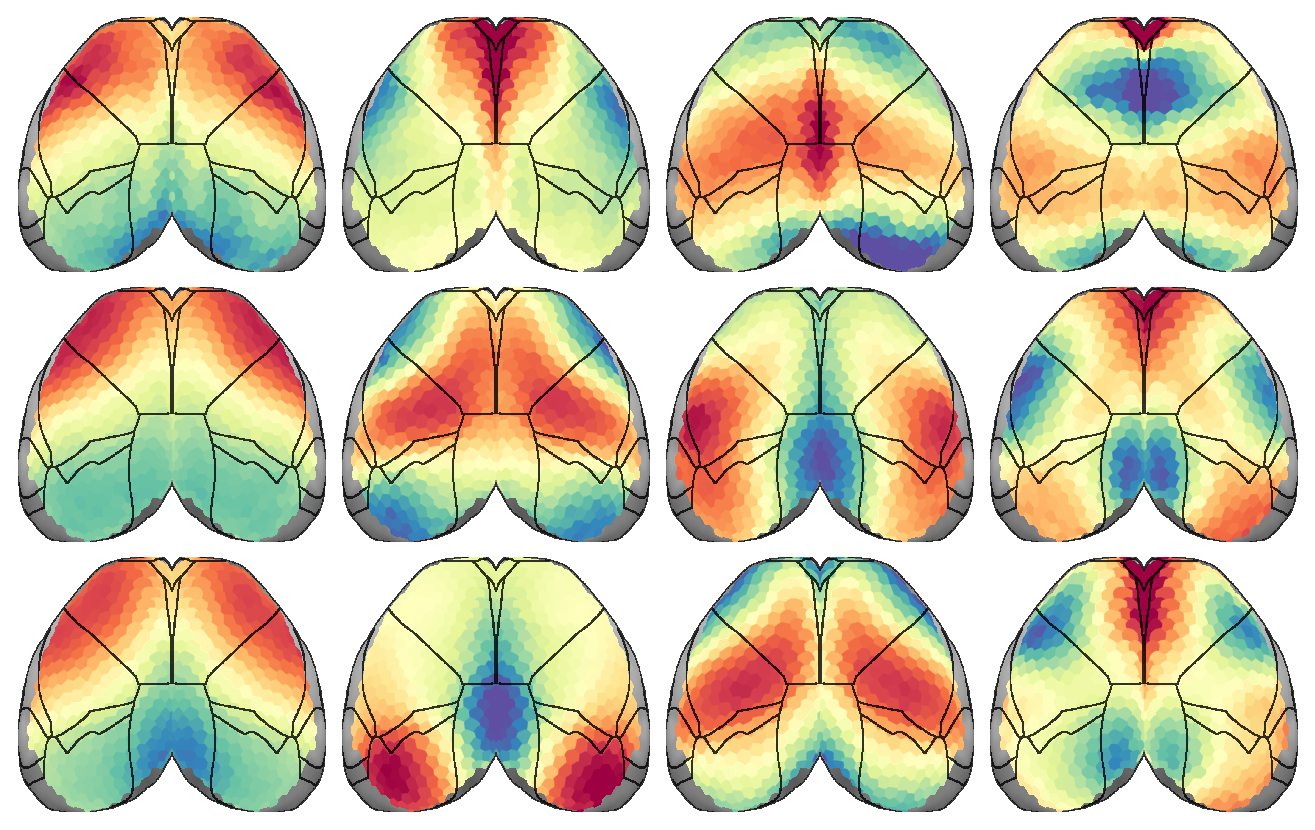

In [9]:
fig = _show_grads_save(x)

### Similarity

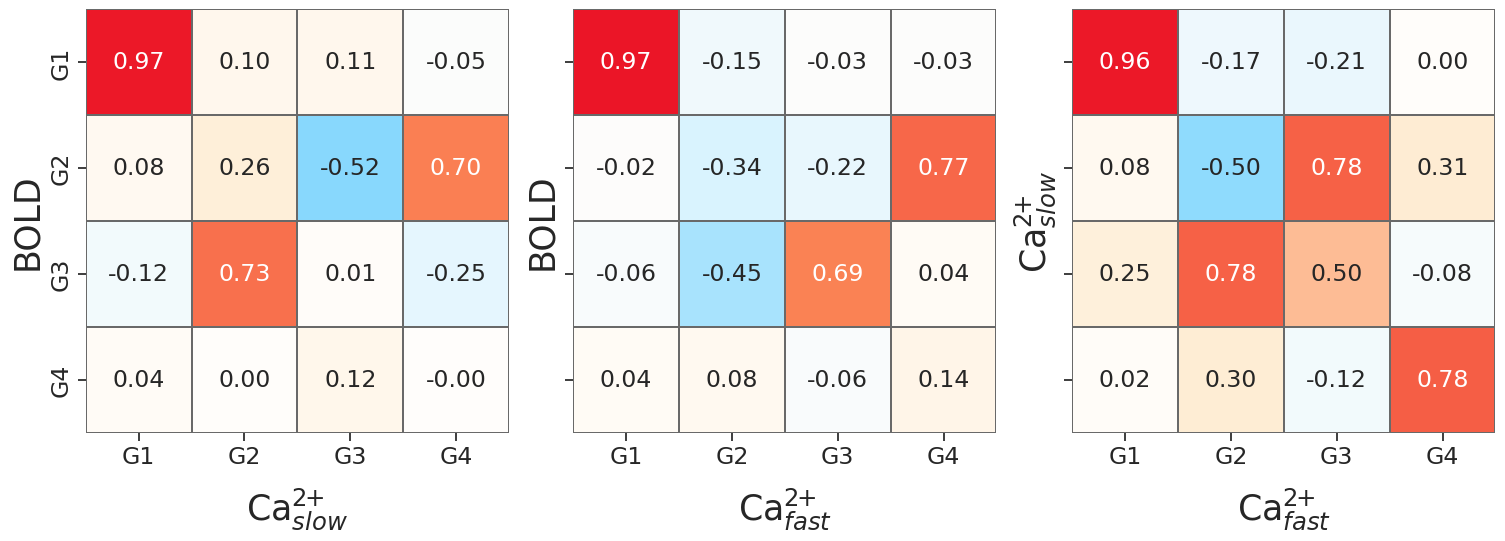

In [10]:
sim = get_sim(x, list(grads))
fig = _show_sim(sim, align=False, fontsize=17, figsize=(15, 5.3))

### Pairwise scatter

In [11]:
df = get_df(x, partition, list(grads))

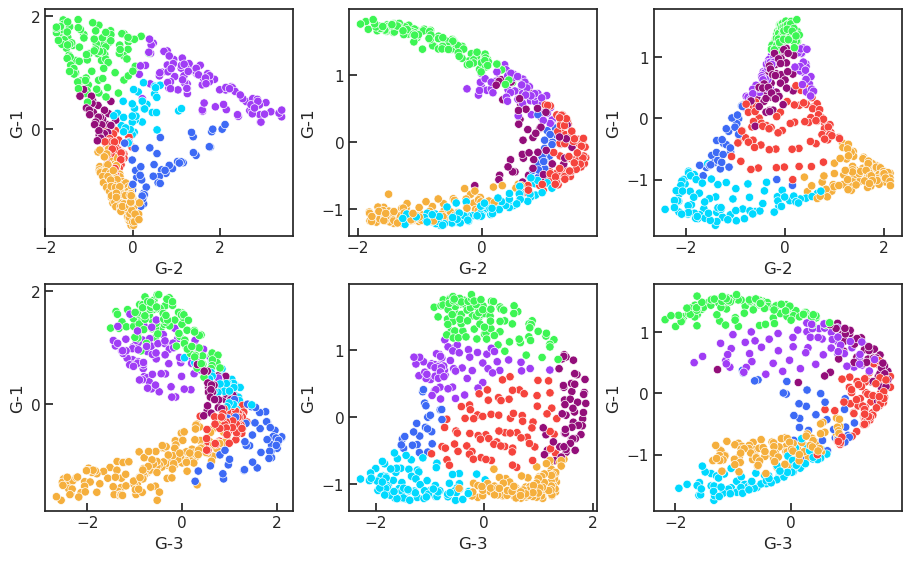

In [12]:
fig, axes = create_figure(2, 3, (9, 5.5), layout='constrained')
for row_i, (i, j) in enumerate([(0, 1), (0, 2)]):
    for col_i, mode in enumerate(grads):
        ax = axes[row_i, col_i]
        d2p = df.loc[df['mode'] == mode]
        sns.scatterplot(
            data=d2p,
            y=f"G-{i+1}",
            x=f"G-{j+1}",
            hue='partition',
            hue_order=colors,
            palette=colors,
            legend=False,
            ax=ax,
        )
        ax.locator_params(nbins=3)
        ax.tick_params(direction="in")
        # ax.set(xlabel='', ylabel='')
plt.show()

### Save Excel

In [13]:
df.to_excel(pjoin(save_dir, "Figure8.xlsx"), index=False)

### Lamb (not saved)

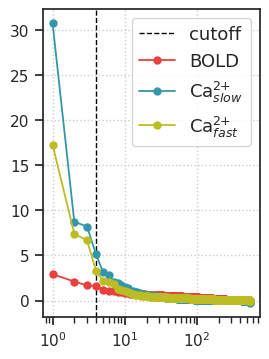

In [14]:
fig = _show_lambs_shared(lambs, (2.8, 4))